In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Expects timeseries.py in same folder as nb. 
from fastai.vision import *
from pathlib import Path
import pdb
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import log_loss
import fastai.callbacks.hooks
import json

In [3]:
path = Path("")

In [4]:
jsIn = json.load((path/"train.json").open())

In [5]:
class ImageWithAngle(Image):
    def __init__(self,px,angle):
        super().__init__(px)
        self.angle = angle
        self.na = 0.0
        if self.angle == "na":
            self.angle = 0.0
            self.na = 1.0
        
    def clone(self):
        return self.__class__(self.px.clone(),self.angle)
        
    @property
    def data(self)->TensorImage:
        return self.px, torch.tensor(self.angle)

In [47]:
class JSONImageItemList(ImageItemList):
    def get(self, i):
        img = self.items[i]
        angle = img["inc_angle"]
        a,b = torch.tensor(img["band_1"]), torch.tensor(img["band_2"])
        a = a / a.min()
        b = b / b.min()
        img = torch.stack([a,b,(a+b)/2],dim=0).view(3,75,75)
        return Image(img)
        
    
    @classmethod
    def from_json(cls,js,**kwargs):
        return cls(js,**kwargs)

In [48]:
src = (JSONImageItemList.from_json(jsIn)
       .random_split_by_pct(0.2)
       #.label_from_func(lambda item: float(item["is_iceberg"])))
       .label_from_func(lambda item: item["is_iceberg"] == 1))

In [49]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = src.transform(tfms,size=75).databunch(bs=16,num_workers=0)#.normalize(imagenet_stats)

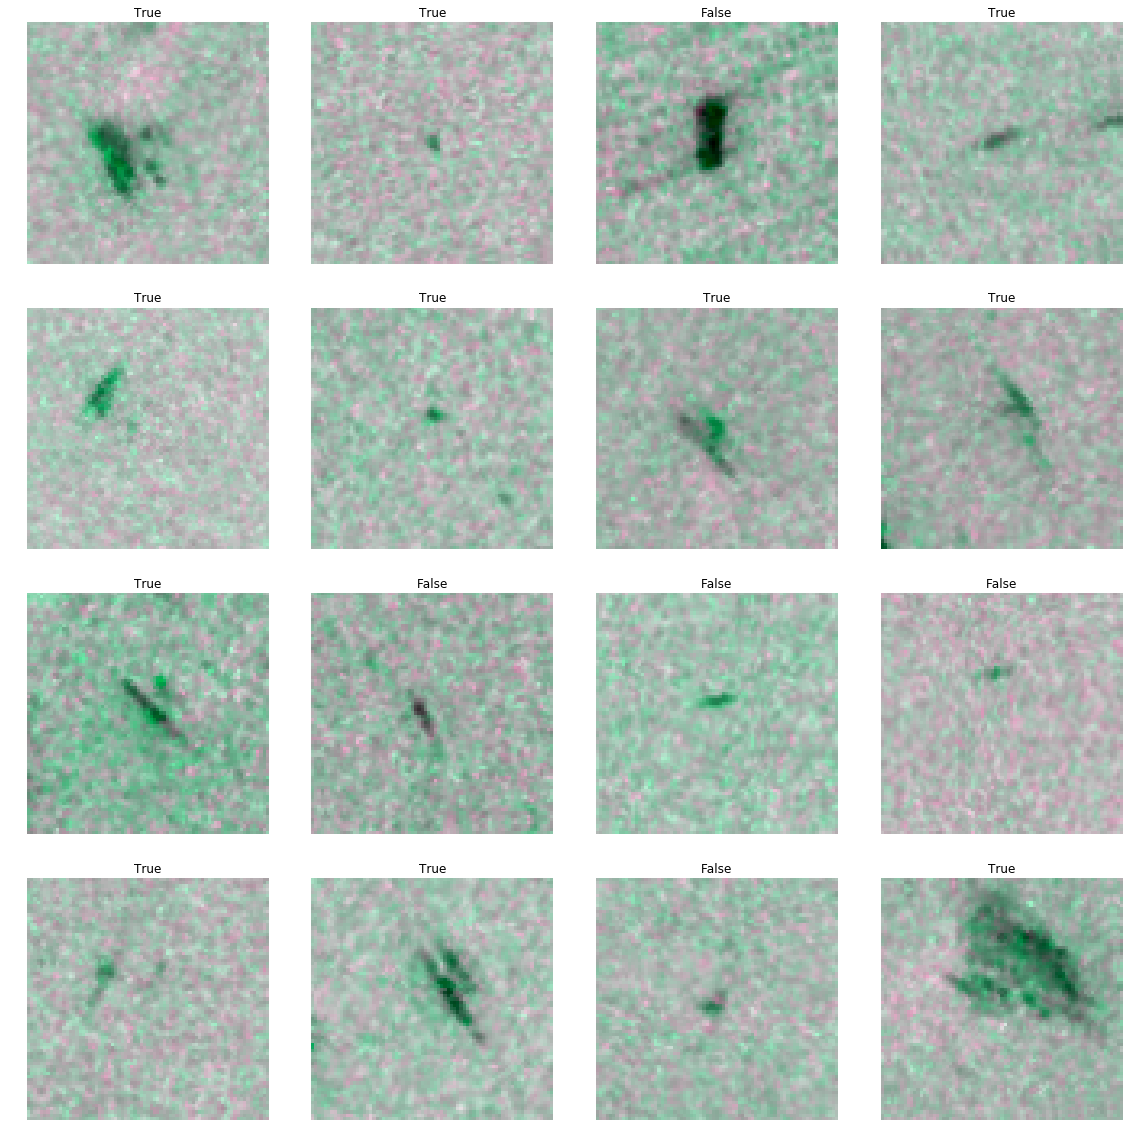

In [51]:
data.show_batch()

In [10]:
class ParallelAlex(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.hero = create_body(models.alexnet,pretrained=True)
        self.parallel = create_body(models.alexnet,pretrained=False)
        self.classifier = create_head(512 * 2,num_classes)
        
    def forward(self, x):
        x = torch.cat([self.hero(x),self.parallel(x)],dim=1)
        return self.classifier(x)

In [11]:
class SidekickAlexNet(nn.Module):
    def __init__(self, num_classes=1000,width=8,pretrained=True):
        super().__init__()
        
        self.hero = create_body(models.alexnet,pretrained=pretrained)
        ml = [f for i,f in enumerate(next(self.hero.children()).children()) if i in [2,5,7,9,12]]
        self.hooks = fastai.callbacks.Hooks(ml,lambda m,i,o: o,detach=False)
        
        self.features = nn.ModuleList(
            [nn.Sequential(conv2d(3, 8*width, ks=11, stride=4, padding=2,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(conv2d(8*width + 64, 24 * width, ks=5, padding=2,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2)),
            nn.Sequential(conv2d(24*width + 192, 48 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True)),
            nn.Sequential(conv2d(48*width + 384, 32 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True)),
            nn.Sequential(conv2d(32*width + 256, 32 * width, ks=3, padding=1,bias=True),nn.ReLU(inplace=True),nn.MaxPool2d(kernel_size=3, stride=2))])
        
        self.classifier = create_head((32*width + 256)*2,num_classes)

    def forward(self, x):
        bs = x.shape[0]
        pt = self.hero(x)
        
        x = self.features[0](x)
        for f, a in zip(self.features[1:],self.hooks.stored):
            x = f(torch.cat([x,a],dim=1))
            
        x = torch.cat([x,pt],dim=1)    
        x = self.classifier(x)
        return x


In [12]:
def logloss(preds,target):
    preds = torch.softmax(preds,dim=1)
    preds = preds.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    return torch.tensor(log_loss(target,preds))

In [28]:
learn = create_cnn(data,models.alexnet,metrics=[accuracy,logloss,FBeta()])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06


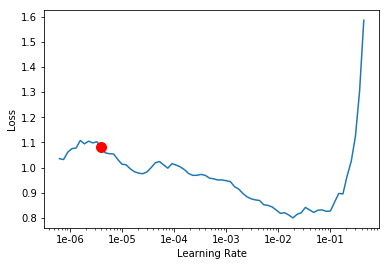

In [55]:
learn.lr_find()
learn.recorder.plot()

In [29]:
learn.freeze()

In [30]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,logloss,f_beta
1,0.618835,0.529966,0.778125,0.529966,0.695153
2,0.563576,0.558903,0.781250,0.558903,0.718789
3,0.551138,0.567008,0.778125,0.567008,0.866051
4,0.576847,0.514935,0.784375,0.514935,0.856643
5,0.530753,0.800180,0.787500,0.581054,0.781441
6,0.505112,0.882970,0.768750,0.588546,0.659767
7,0.485632,0.428659,0.809375,0.428659,0.833333
8,0.445635,0.945483,0.790625,0.564332,0.739348
9,0.434082,0.434322,0.821875,0.434322,0.792079
10,0.417784,0.996040,0.806250,0.670669,0.832335


In [31]:
learn.unfreeze()
learn.fit_one_cycle(20,1e-5)

epoch,train_loss,valid_loss,accuracy,logloss,f_beta
1,0.431910,0.565436,0.803125,0.555573,0.815217
2,0.435496,0.573233,0.806250,0.571248,0.774473
3,0.449515,1.187995,0.793750,0.879416,0.757764
4,0.413235,0.513726,0.825000,0.513726,0.805658
5,0.419744,0.572917,0.803125,0.572917,0.760598
6,0.394050,0.680956,0.840625,0.569439,0.814815
7,0.389022,3.148722,0.793750,1.043818,0.779141
8,0.379460,0.758716,0.796875,0.730490,0.771605
9,0.410839,1.038003,0.806250,0.715387,0.803898
10,0.386914,1.259821,0.815625,0.894713,0.827295


In [43]:
learnSK = Learner(data,SidekickAlexNet(data.train_ds.c,width=8),metrics=[accuracy,logloss,FBeta()])
learnSK.split([learnSK.model.hero,learnSK.model.features[0],learnSK.model.classifier])

In [44]:
learnSK.model(next(iter(data.train_dl))[0]).shape

torch.Size([16, 2])

In [45]:
learnSK.freeze_to(1)

In [46]:
learnSK.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy,logloss,f_beta
1,0.508887,0.371067,0.825000,0.371067,0.763689
2,0.442418,0.769964,0.609375,0.769964,0.850299
3,0.408222,0.682439,0.709375,0.682439,0.884184
4,0.408141,1.484003,0.540625,1.484003,0.828471
5,0.388629,3.303072,0.553125,3.303071,0.000000
6,0.392544,5.215890,0.443750,5.215890,nan
7,0.406921,0.550429,0.743750,0.550429,0.515625
8,0.341731,1.002846,0.637500,1.002846,0.226510
9,0.379149,0.338348,0.865625,0.338348,0.900409
10,0.348476,0.720333,0.671875,0.720333,0.320197


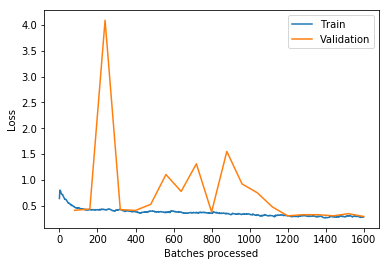

In [17]:
learnSK.recorder.plot_losses()

In [27]:
learnSK.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,logloss,f_beta
1,0.264916,0.284691,0.868750,0.284691,0.884477
2,0.290757,0.286044,0.875000,0.286044,0.862913
3,0.299149,0.280467,0.865625,0.280467,0.902613
4,0.266935,0.278672,0.875000,0.278672,0.874848
5,0.272107,0.277284,0.875000,0.277284,0.874848
6,0.285651,0.279073,0.871875,0.279073,0.869830
7,0.284098,0.281220,0.878125,0.281220,0.867971
8,0.287933,0.284100,0.875000,0.284100,0.866911
9,0.267158,0.284716,0.865625,0.284716,0.894988
10,0.278133,0.277108,0.878125,0.277108,0.875912


In [ ]:
learnSK.save("sz128")

In [224]:
learnP = Learner(data,ParallelAlex(data.train_ds.c),metrics=[accuracy,logloss])
learnP.split([learnP.model.hero,learnP.model.parallel,learnP.model.classifier])

In [225]:
learnP.freeze_to(1)

In [226]:
learnP.fit_one_cycle(20,1e-3)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.556228,0.517807,0.743750,0.517807
2,0.457587,2.601780,0.553125,2.601781
3,0.443389,0.487029,0.746875,0.487029
4,0.426558,0.467504,0.756250,0.467504
5,0.452909,0.995536,0.575000,0.995536
6,0.443796,0.501301,0.778125,0.501301
7,0.423956,0.367492,0.828125,0.367492
8,0.438929,0.414534,0.771875,0.414534
9,0.412402,1.800288,0.559375,1.800288
10,0.412454,0.346541,0.834375,0.346541


In [227]:
learnP.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy,logloss
1,0.374677,0.345647,0.825000,0.345647
2,0.347925,0.302350,0.846875,0.302350
3,0.361515,0.337443,0.840625,0.337443
4,0.346335,0.300358,0.853125,0.300358
5,0.371964,0.463704,0.759375,0.463704
6,0.368361,0.408657,0.815625,0.408657
7,0.348326,0.354264,0.834375,0.354263
8,0.361991,0.324385,0.865625,0.324385
9,0.349180,0.313714,0.856250,0.313714
10,0.350429,0.294424,0.875000,0.294424
